# Movie Clustering
Cluster movies depending on genre.
___

## Exploratory Data Analysis
___
### 1. Genres
Genres will be valuable for clustering similar movies, so we will need to one-hot-encode the different genres.

In [187]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

dfMovies  = pd.read_csv('../data/movies.csv')
dfRatings = pd.read_csv('../data/ratings.csv')
# Remove some ratings, because there are so many
dfRatings = dfRatings.sample(frac=.25, replace=True, random_state=1)
dfRatings = dfRatings.reset_index(drop=True)
dfLinks   = pd.read_csv('../data/links.csv')
dfTags    = pd.read_csv('../data/tags.csv')
dfMovies.dropna()
dfRatings.dropna()
dfLinks.dropna()
dfTags.dropna()
display(dfMovies.head())
display(dfRatings.head())
display(dfLinks.head())
display(dfTags.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,87846,3438,4.0,974677613
1,46532,2042,3.0,1297805055
2,85148,30749,5.0,1237056850
3,3306,6503,3.0,1069194407
4,92733,1801,5.0,1104026134


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


### 2. Tags
As shown below, there are 38,644 unique tags and many are niche or include foreign characters. For this reason, I will not be using them in my models.

One could try to calculate which movies had similar tags, as well as genre. I will only be using genre.

In [188]:
import random

uniqueTags = list(np.unique(dfTags["tag"].values.astype(str)))

print("Number of Unique Tags: " + str(len(uniqueTags)))
print("A Few Tags:")
for i in random.sample(uniqueTags, 15):
    print(i, end=", ")

Number of Unique Tags: 38644
A Few Tags:
orlando bloom, Liam Lynch, outer space, Toho Company Ltd., safe (for valuables), BOUNTY HUNTERS, God-given right to kill?, MF, see also:Peter Pan, phantasmagoric, Alfred Hitchcock, William R. Moses, Carey Elwes, janitor, Sweet thriller, 

## Feature Engineering
___
### 1. One-Hot-Encode Genre

In [189]:
# Store the genres for each index
genres_df = dfMovies.genres.str.split('|', expand=True)
genres_df.head()

# Get unique genres
genres = []
for i in genres_df.values.flatten():
    if not (i in genres):
        genres.append(i)
genres.remove(None)
genres = sorted(genres)

# Insert one-hot-encoded columns
for g in genres:
    dfMovies.insert(
        2,
        g,
        [int(g in i) for i in dfMovies.genres.str.split('|', expand=False)],
        False
    )
dfMovies

del dfMovies["genres"]
del dfMovies["(no genres listed)"]
dfMovies.head(3)

,movieId,title,Western,War,Thriller,Sci-Fi,Romance,Mystery,Musical,IMAX,Horror,Film-Noir,Fantasy,Drama,Documentary,Crime,Comedy,Children,Animation,Adventure,Action
0,1,Toy Story (1995),0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,0
1,2,Jumanji (1995),0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### 2. Add Average Rating and Number of Ratings
Calculate the average rating and number of ratings for each movie, and add those values to the dataframe.

In [190]:
# Create columns for a movie's average rating and number of ratings
dfMovies['AvgRating'] = dfMovies['movieId'].map(
    lambda x: dfRatings.loc[dfRatings['movieId'] == x]['rating'].mean()
)
dfMovies['NumOfRatings'] = dfMovies['movieId'].map(
    lambda x: dfRatings.loc[dfRatings['movieId'] == x]['rating'].count()
)
dfMovies.head(3)

,movieId,title,Western,War,Thriller,Sci-Fi,Romance,Mystery,Musical,IMAX,Horror,Film-Noir,Fantasy,Drama,Documentary,Crime,Comedy,Children,Animation,Adventure,Action,AvgRating,NumOfRatings
0,1,Toy Story (1995),0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,0,3.918550,12388
1,2,Jumanji (1995),0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,3.225432,5607
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3.142382,3157


### 3. Remove Movies With Few Ratings
We will sort the movies based off of the average rating. We want to make sure each movie has enough ratings for the average rating to be accurate.

In [191]:
dfMovies = dfMovies[dfMovies.NumOfRatings >= 50]

## Models
___
### Determine Number of Clusters
I will cluster based off of the genres. We don't want to cluster based off of average rating or number of ratings because then we might cluster around bad movies or movies who weren't heavily reviewed.

I will create an elbow graph to decide how many clusters we want. We want to pick the maximum amount of clusters that still signifigantly reduces distance, i.e. the "elbow" of the lineplot.

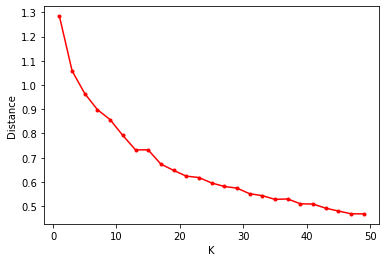

In [192]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

dfMovies.dropna(inplace=True)

# Cluster based off of the genres
clusterFeatures = dfMovies.copy()
del clusterFeatures["movieId"]
del clusterFeatures["title"]
del clusterFeatures["AvgRating"]
del clusterFeatures["NumOfRatings"]

distances = []
K = range(1, 50, 2)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(clusterFeatures)
    kmeanModel.fit(clusterFeatures)
    distances.append(
        sum(np.min(cdist(clusterFeatures, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / clusterFeatures.shape[0]
    )

# Plot the elbow graph
plt.plot(K, distances, 'r.-')
plt.xlabel('Elbow Graph')
plt.xlabel('K')
plt.ylabel('Distance')
plt.show()

Based on the elbow graph, I will have 20 clusters.

### 1. K-Means Clustering
Form centroids around our 20 clusters.

### 2. Agglomerative Clustering
Repeatedly merge clusters based off of distance.

#### Both Created Below:

In [193]:
numClusters = 20

# K-Means Clustering
kmeans = KMeans(n_clusters=numClusters, random_state=0).fit_predict(clusterFeatures)

# Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering
AgglCluster = AgglomerativeClustering(n_clusters=numClusters).fit_predict(clusterFeatures)

dfMovies["KMeansCluster"] = pd.DataFrame(kmeans)
dfMovies["AgglCluster"] = AgglCluster
dfMovies.head()

,movieId,title,Western,War,Thriller,Sci-Fi,Romance,Mystery,Musical,IMAX,Horror,Film-Noir,Fantasy,Drama,Documentary,Crime,Comedy,Children,Animation,Adventure,Action,AvgRating,NumOfRatings,KMeansCluster,AgglCluster
0,1,Toy Story (1995),0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,0,3.918550,12388,11.0,3
1,2,Jumanji (1995),0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,3.225432,5607,19.0,3
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3.142382,3157,5.0,18
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,2.793985,665,4.0,19
4,5,Father of the Bride Part II (1995),0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3.080992,3025,7.0,4


Columns KMeansCluster and AgglCluster indicate which cluster a movie is in, based off of the two different models.

### Create a Movie Suggestion Generator
I created a function that, given a movie and a cluster type, returns the 8 highest rated movies within that cluster.

In [202]:
def printMovieSuggestions(movie, clusterName):
    cluster = dfMovies.loc[dfMovies["title"] == movie][clusterName].values[0]
    clusterMovies = dfMovies.copy().loc[dfMovies[clusterName] == cluster]
    # Sort the movies within the cluster based off of average rating and number of ratings
    clusterMovies.sort_values(by=["AvgRating", "NumOfRatings"], ascending=False, inplace=True)
    return pd.DataFrame(clusterMovies['title'].values).head(8)

### Testing Our Suggestion Generator
Print off the top movies within the same cluster for Toy Story, The Lord of the Rings: The Two Towers, and The Matrix.

In [203]:
print("Toy Story (1995):\n")
print("K-Means Clustering:")
display(printMovieSuggestions("Toy Story (1995)", "KMeansCluster"))
print("Agglomerative Clustering:")
display(printMovieSuggestions("Toy Story (1995)", "AgglCluster"))

Toy Story (1995):

K-Means Clustering:


,0
0,"Apartment, The (1960)"
1,"Hate (Haine, La) (1995)"
2,Trust (1990)
3,"39 Steps, The (1935)"
4,Ferris Bueller's Day Off (1986)
5,Toy Story (1995)
6,Raising Arizona (1987)
7,Take the Money and Run (1969)


Agglomerative Clustering:


,0
0,Spirited Away (Sen to Chihiro no kamikakushi) ...
1,Wallace & Gromit: The Wrong Trousers (1993)
2,My Neighbor Totoro (Tonari no Totoro) (1988)
3,Wallace & Gromit: A Close Shave (1995)
4,Anne of Green Gables (1985)
5,Grave of the Fireflies (Hotaru no haka) (1988)
6,Nausicaä of the Valley of the Wind (Kaze no ta...
7,Creature Comforts (1989)


In [204]:
print("Lord of the Rings: The Two Towers, The (2002):\n")
print("K-Means Clustering:")
display(printMovieSuggestions("Lord of the Rings: The Two Towers, The (2002)", "KMeansCluster"))
print("Agglomerative Clustering:")
display(printMovieSuggestions("Lord of the Rings: The Two Towers, The (2002)", "AgglCluster"))

Lord of the Rings: The Two Towers, The (2002):

K-Means Clustering:


,0
0,Spirited Away (Sen to Chihiro no kamikakushi) ...
1,"Maltese Falcon, The (1941)"
2,"General, The (1926)"
3,Grave of the Fireflies (Hotaru no haka) (1988)
4,"Lord of the Rings: The Two Towers, The (2002)"
5,Rebecca (1940)
6,Burden of Dreams (1982)
7,Secrets & Lies (1996)


Agglomerative Clustering:


,0
0,Monty Python and the Holy Grail (1975)
1,"Lord of the Rings: The Fellowship of the Ring,..."
2,"Lord of the Rings: The Two Towers, The (2002)"
3,Time of the Gypsies (Dom za vesanje) (1989)
4,It's a Wonderful Life (1946)
5,8 1/2 (8½) (1963)
6,Brazil (1985)
7,"Wings of Desire (Himmel über Berlin, Der) (1987)"


In [206]:
print("Matrix, The (1999):\n")
print("K-Means Clustering:")
display(printMovieSuggestions("Matrix, The (1999)", "KMeansCluster"))
print("Agglomerative Clustering:")
display(printMovieSuggestions("Matrix, The (1999)", "AgglCluster"))

Matrix, The (1999):

K-Means Clustering:


,0
0,To Kill a Mockingbird (1962)
1,"Big Sleep, The (1946)"
2,"Matrix, The (1999)"
3,M (1931)
4,Red Beard (Akahige) (1965)
5,That Obscure Object of Desire (Cet obscur obje...
6,Butch Cassidy and the Sundance Kid (1969)
7,Big Night (1996)


Agglomerative Clustering:


,0
0,City of God (Cidade de Deus) (2002)
1,Star Wars: Episode IV - A New Hope (1977)
2,"Matrix, The (1999)"
3,Star Wars: Episode V - The Empire Strikes Back...
4,Blade Runner (1982)
5,"Wages of Fear, The (Salaire de la peur, Le) (1..."
6,Aliens (1986)
7,"Bourne Identity, The (1988)"


### Conclusion:
**Agglomerative Clustering seems to be more accurate than K-means clustering. I see more similarities between movies that the Agglomerative Clustering model suggested.**